In [3]:
using LibSndFile
using Mocha
using PyPlot
using WaveletScattering
ws = WaveletScattering

WaveletScattering

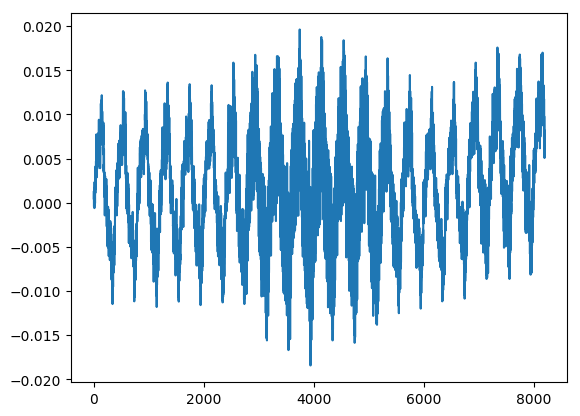

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x331f446d0>

In [70]:
chirp = LibSndFile.load("/Users/vl238/dev/fall2015_clip_dataset/data/clips/unit10/unit10_1_2524648.wav")
#chirp = LibSndFile.load("unit10_1_2524648.wav")
data = [ Float32(x) for x in collect(chirp) ]
plot(data)

28-Feb 16:34:47:INFO:root:Constructing net network on Mocha.CPUBackend...
28-Feb 16:34:47:INFO:root:Topological sorting 5 layers...
28-Feb 16:34:47:INFO:root:Setup layers...
28-Feb 16:34:47:INFO:root:Network constructed!


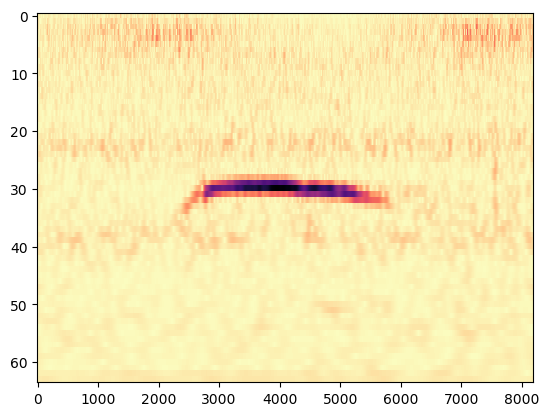

  0.264443 seconds (1.67 M allocations: 46.200 MB, 3.88% gc time)


PyObject <matplotlib.image.AxesImage object at 0x32b157210>

In [76]:
J = 4
Q = 16

spec = ws.Spec1D(log2_size=13, max_qualityfactor=Q, n_filters_per_octave=Q, n_octaves=J)
bank = ws.Bank1D(spec, max_log2_stride=0)

backend = Mocha.CPUBackend()
signal = ws.InputLayer(
    data = data,
    tops = [:signal],
    symbols = [:time, :chunk])

fourier = ws.FourierLayer(
    bottoms = [:signal],
    pathkeys = [ws.PathKey(:time)],
    tops = [:fourier])

wavelets = ws.WaveletLayer(
    bank = bank,
    bottoms = [:fourier],
    tops = [:wavelets])

invfourier = ws.InvFourierLayer(
    bottoms = [:wavelets],
    pathkeys = [ws.PathKey(:time)],
    tops = [:invfourier])

modulus = ws.PointwiseLayer(
    bottoms = [:invfourier],
    tops = [:modulus],
    ρ = ws.Modulus())

layers = Mocha.Layer[
    signal,
    fourier,
    wavelets,
    invfourier,
    modulus]

Mocha.init(backend)
@time net = Mocha.Net("network", backend, layers);

paths = [ ws.Path(ws.PathKey(:j,:time) => j) for j in 0:(J-1)]
octaves = [ net.states[end].blobs[1].nodes[path].data for path in paths]

U1 = cat(4, octaves...)
U1 = reshape(U1, size(U1, 1), size(U1, 3) * size(U1, 4))

imshow(-U1[:, :].', aspect="auto", cmap=ColorMap("magma"))